In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt

In [2]:
keras.mixed_precision.set_global_policy("mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [4]:
x_train = x_train.reshape((-1, 28 * 28)).astype("float32") / 255
x_test = x_test.reshape((-1, 28 * 28)).astype("float32") / 255
x_train_full = x_train[:]
y_train_full = y_train[:]

In [5]:
num_val_samples = 10000
x_train, x_val = x_train[:-num_val_samples], x_train[-num_val_samples:]
y_train, y_val = y_train[:-num_val_samples], y_train[-num_val_samples:]

In [6]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

In [7]:
def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [8]:
tuner = kt.BayesianOptimization(build_model, objective="val_accuracy", max_trials=1, executions_per_trial=2, directory="mnist_kt_test", overwrite=True)

In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


In [10]:
tuner.search(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val), callbacks=callbacks, verbose=2)

Trial 1 Complete [00h 02m 18s]
val_accuracy: 0.9690999984741211

Best val_accuracy So Far: 0.9690999984741211
Total elapsed time: 00h 02m 18s
INFO:tensorflow:Oracle triggered exit


In [11]:
top_n = 4
best_hps = tuner.get_best_hyperparameters(top_n)

In [12]:
def get_best_epoch(hp):
    model = build_model(hp)
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)]
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=128, callbacks=callbacks)
    val_loss_per_epoch = history.history["val_loss"]
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch, model

In [13]:
def get_best_trained_model(hp):
    best_epoch, model = get_best_epoch(hp)
    model.fit(x_train_full, y_train_full, batch_size=128, epochs=int(best_epoch * 1.2))
    return model

In [14]:
best_models = []
for hp in best_hps:
    model = get_best_trained_model(hp)
    model.evaluate(x_test, y_test)
    best_models.append(model)

Epoch 1/100
391/391 [==============================] - 8s 20ms/step - loss: 0.4585 - accuracy: 0.8794 - val_loss: 0.2469 - val_accuracy: 0.9323
Epoch 2/100
391/391 [==============================] - 8s 19ms/step - loss: 0.2358 - accuracy: 0.9336 - val_loss: 0.2025 - val_accuracy: 0.9428
Epoch 3/100
391/391 [==============================] - 7s 19ms/step - loss: 0.1874 - accuracy: 0.9459 - val_loss: 0.1720 - val_accuracy: 0.9521
Epoch 4/100
391/391 [==============================] - 7s 19ms/step - loss: 0.1577 - accuracy: 0.9543 - val_loss: 0.1508 - val_accuracy: 0.9563
Epoch 5/100
391/391 [==============================] - 8s 19ms/step - loss: 0.1381 - accuracy: 0.9606 - val_loss: 0.1392 - val_accuracy: 0.9604
Epoch 6/100
391/391 [==============================] - 7s 18ms/step - loss: 0.1234 - accuracy: 0.9646 - val_loss: 0.1304 - val_accuracy: 0.9632
Epoch 7/100
391/391 [==============================] - 7s 17ms/step - loss: 0.1115 - accuracy: 0.9677 - val_loss: 0.1256 - val_accuracy:

In [15]:
preds = best_models[0].predict(x_test).tolist()

In [16]:
preds[0]

[0.0, 0.0, 0.0, 2.980232238769531e-07, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [17]:
preds[0].index(max(preds[0]))

7

In [18]:
copy = x_test[0]

In [19]:
copy = copy.reshape(28, 28, 1)

In [20]:
copy.shape

(28, 28, 1)

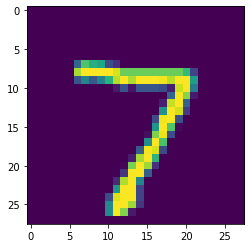

In [21]:
imgplot = plt.imshow(copy)

In [23]:
model.save('mnist_model', save_format="tf")

INFO:tensorflow:Assets written to: mnist_model\assets
